# **KAGGLE di ALESSANDRO DELL'ORTO (num matricola 876909)**

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import IFrame

IFrame(src='https://en.wikipedia.org/wiki/Titanic', width=700, height=500)

# Load the train data

Firstly, we must load the dataset. We use [Panda](https://pandas.pydata.org/) .

In [3]:
train_data = pd.read_csv("train.csv", encoding="utf8", converters={'Sex': lambda x: int(x == 'male'), 'Embarked' : lambda x: (1 if x=='C' else 0 if x =='Q' else -1 if x=='S' else np.nan)} )

In [4]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,-1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,-1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,-1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,-1.0
5,6,0,3,"Moran, Mr. James",1,NaN,0,0,330877,8.4583,NaN,0.0
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,-1.0
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,-1.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,NaN,-1.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,NaN,1.0


In [5]:
train_data.PassengerId.unique().shape

(891,)

# Analyse features

In [6]:
def bar_chart(feature):
    survived = train_data[train_data['Survived']==1][feature].value_counts()
    dead = train_data[train_data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(15,7))

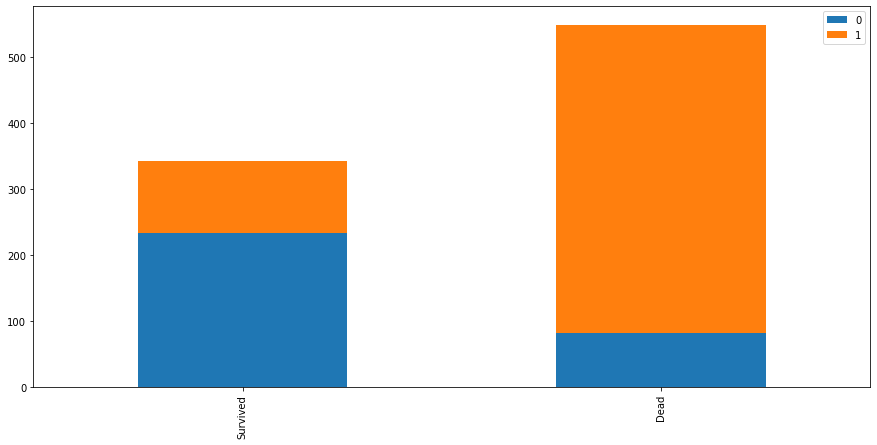

In [7]:
bar_chart('Sex')

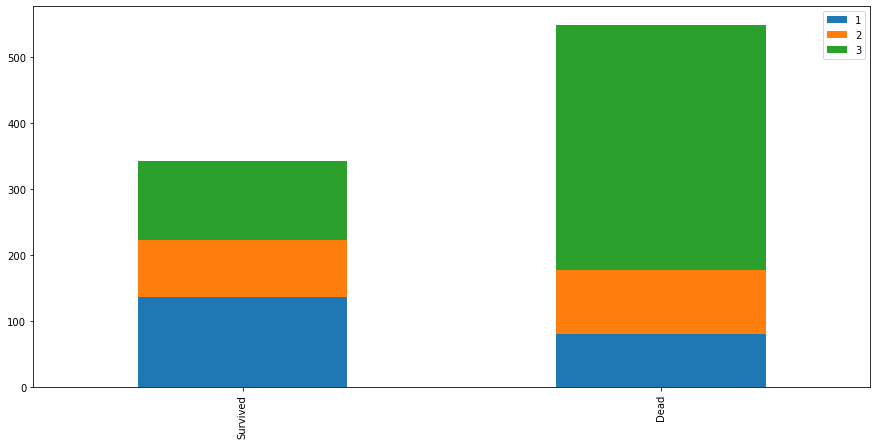

In [8]:
bar_chart('Pclass')

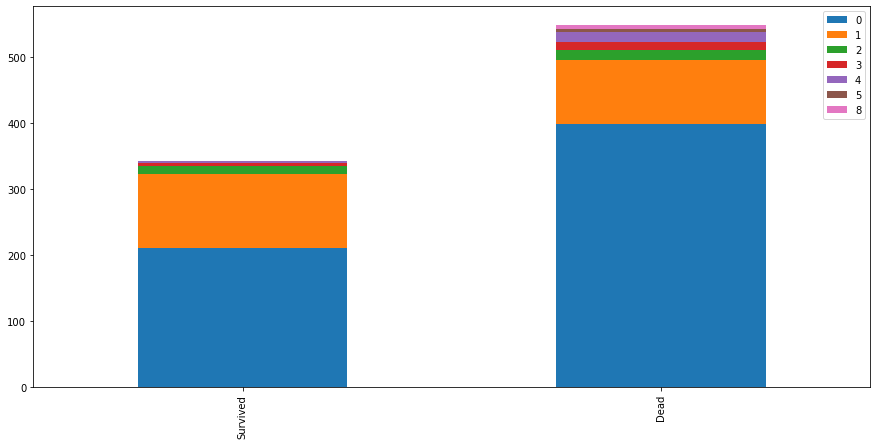

In [9]:
bar_chart('SibSp')

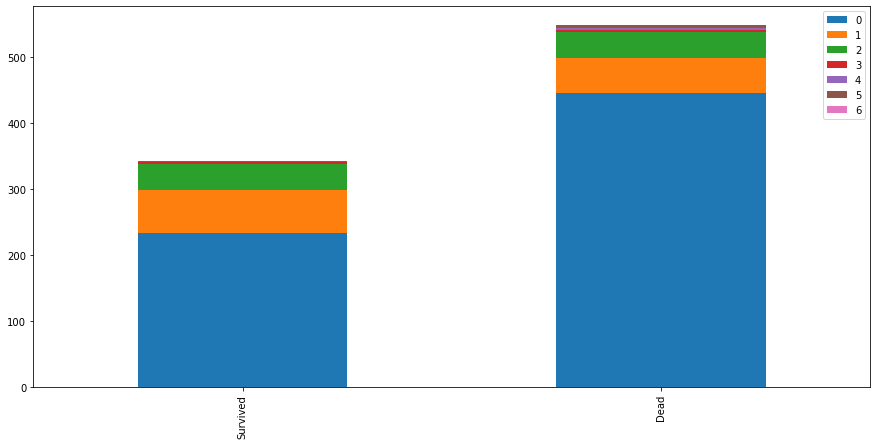

In [10]:
bar_chart('Parch')

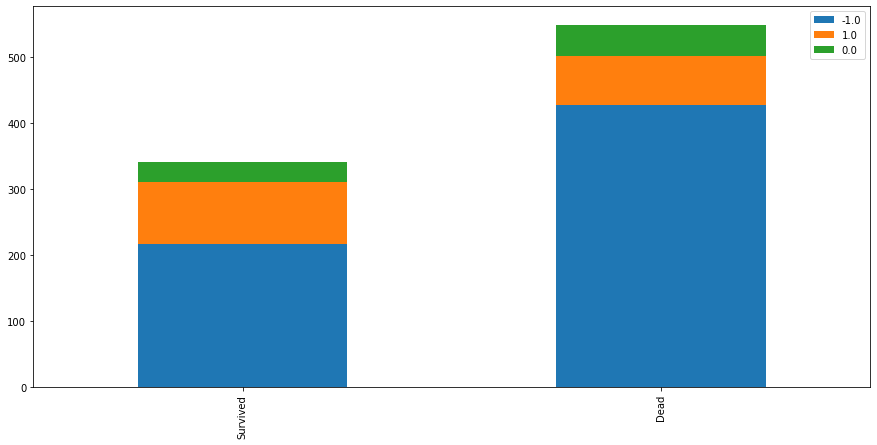

In [11]:
bar_chart('Embarked')

how much NaN value are there?

In [12]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Remove "Cabin" feature, too much NaN

## Select features and extract the target

Remove 'Survived','Name','PassengerId','Ticket' features

In [13]:
X = train_data.drop(columns=['Survived','Name','PassengerId','Ticket','Cabin'])
y = train_data['Survived']

In [14]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

## Data imputation

Delete NaN value from Age.
https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

In [15]:
from sklearn.impute import KNNImputer

In [16]:
imputer = KNNImputer(n_neighbors=4,missing_values=np.nan)

In [17]:
X_i=imputer.fit_transform(X)

In [18]:
sum(np.isnan(X_i))

0

## Search Correlation

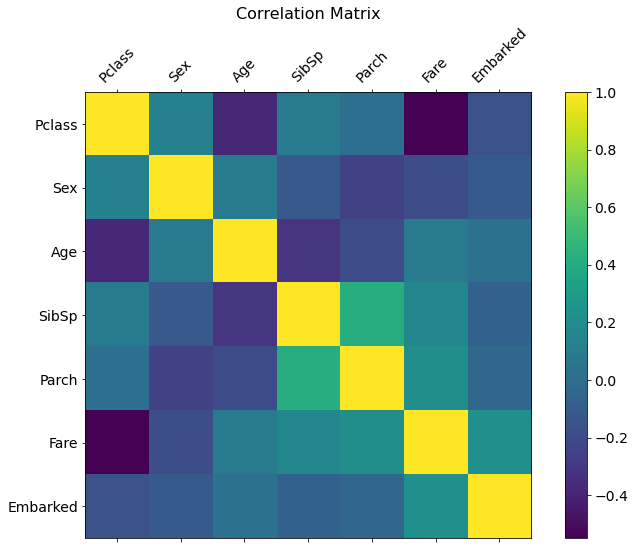

In [19]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12, 8))
plt.matshow(X.corr(), fignum=f.number)
plt.xticks(range(X.shape[1]), X.columns, fontsize=14, rotation=45)
plt.yticks(range(X.shape[1]), X.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Model Selection

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
"""
We are going to try different model and choose the one with best score
"""
models = OrderedDict([
          ('Knn', KNeighborsClassifier()),
          ('Logistic Regression', LogisticRegression(max_iter=10000)),
          ('Linear SVM', SVC(kernel='linear', probability=True)),
          ('Poly SVM', SVC(kernel='poly',  probability=True)),
          ('RBF SVM', SVC(kernel='rbf',  probability=True)),
          ('Classification Tree', DecisionTreeClassifier()),
          ('Random Forest', RandomForestClassifier()),
          ('Multilayer Perceptron', MLPClassifier(activation='tanh',solver='adam', max_iter=10000,
                                                  learning_rate_init=0.001, random_state=0))
          ])


def training(X,y,model='Logistic Regression'):
    scorers    = {'f1_score': make_scorer(f1_score),
              'accuracy_score': make_scorer(accuracy_score),
              'precision_score': make_scorer(precision_score)
             }
    if model=='Knn':
        n_neighbors=[1,2,3,4,5,10,20,30]
        knn=models[model]
        gs = GridSearchCV(knn,param_grid={"n_neighbors": n_neighbors},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Gauss Naive Bayes':
        var_smoothing=np.logspace(-10,-6,20)
        gnb=models[model]
        gs = GridSearchCV(gnb,param_grid={"var_smoothing": var_smoothing},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        if sparse.issparse(X):
            Z=X.toarray()
            gs.fit(Z, y)
        else:
            gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Multi Naive Bayes':
        alpha=np.logspace(-3,0,20)
        mnb=models[model]
        gs = GridSearchCV(mnb,param_grid={"alpha": alpha},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Logistic Regression':
        C  = np.logspace(-3,2,5)
        lr = models[model]
        gs = GridSearchCV(lr,param_grid={"C": C},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Linear SVM':
        C=np.logspace(-3,2,5)
        lsvm=models[model]
        gs = GridSearchCV(lsvm,param_grid={"C": C},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='RBF SVM':
        gamma=np.logspace(-4,1,10)
        C=np.logspace(-3,3,10)
        rsvm=models[model]
        gs = GridSearchCV(rsvm,param_grid={"C": C,"gamma":gamma},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Classification Tree':
        max_depth=[30,40,50,100]
        ct=models[model]
        gs = GridSearchCV(ct,param_grid={"max_depth": max_depth},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=2)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Random Forest':
        max_depth=np.arange(1,10,1)
        n_estimators=np.arange(10,25,1)
        rf=models[model]
        gs = GridSearchCV(rf,param_grid={"max_depth": max_depth,"n_estimators": n_estimators},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=1)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_
    
    if model=='Multilayer Perceptron':
        hidden_layer_sizes=[(5,4,3,2),(6,5,4,3,2),(7,6,5,4,3,2),(8,7,6,5,4,3,2)]
        mlp=models[model]
        gs = GridSearchCV(mlp,param_grid={"hidden_layer_sizes": hidden_layer_sizes},scoring=scorers,refit='f1_score',cv=10,n_jobs=-3,verbose=5)
        gs.fit(X, y)
        return gs, gs.best_params_, gs.best_score_

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,target_names,title='Confusion matrix', cmap=None,normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

Split data in test and train

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_i, y,random_state=42)

In [23]:
target_names = ['Survived','Not Survived']

## K nearest neighbours

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-3)]: Done  73 out of  80 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-3)]: Done  80 out of  80 | elapsed:    2.0s finished


Best parameter: {'n_neighbors': 3}


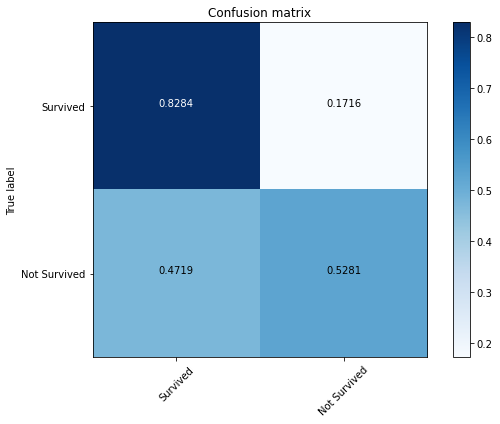

In [24]:
mm,bp,bs=training(X_train,y_train,'Knn')
print ('Best parameter:', bp)
#print ('Best accuracy:', bs)

predic = mm.predict(X_test)
confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

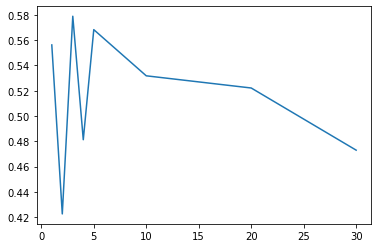

In [25]:
plt.plot([1,2,3,4,5,10,20,30],mm.cv_results_['mean_test_f1_score'])

In [26]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.73      0.83      0.77       134
           1       0.67      0.53      0.59        89

    accuracy                           0.71       223
   macro avg       0.70      0.68      0.68       223
weighted avg       0.70      0.71      0.70       223



In [27]:
best_knn=mm.best_estimator_
best_knn.fit(X_i,y)
scores=cross_val_score(best_knn, X_i, y, cv=5,scoring=make_scorer(f1_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.60 (+/- 0.05)


## Logistic Regression

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-3)]: Done  50 out of  50 | elapsed:    0.4s finished


Best parameter: {'C': 5.623413251903491}


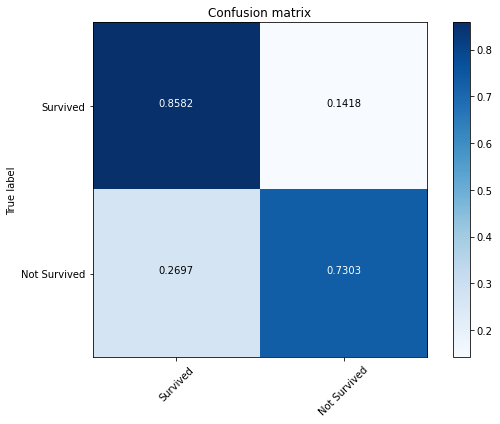

In [28]:
mm,bp,bs=training(X_train,y_train,'Logistic Regression')
print ('Best parameter:', bp)
#print ('Best accuracy:', bs)

predic = mm.predict(X_test)
confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

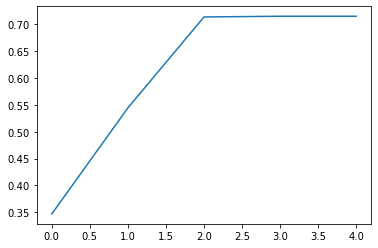

In [29]:
plt.plot(mm.cv_results_['mean_test_f1_score'])

In [30]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       134
           1       0.77      0.73      0.75        89

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223



In [31]:
best_lr=mm.best_estimator_
best_lr.fit(X_i,y)
scores=cross_val_score(best_lr, X_i, y, cv=5,scoring=make_scorer(f1_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.05)


## Random Forest 

Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-3)]: Done 200 tasks      | elapsed:    1.8s


Best parameter: {'max_depth': 5, 'n_estimators': 12}


[Parallel(n_jobs=-3)]: Done 1350 out of 1350 | elapsed:    8.7s finished


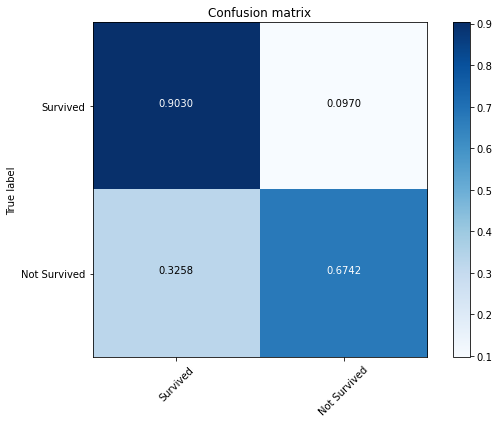

In [32]:
mm,bp,bs=training(X_train,y_train,'Random Forest')
print ('Best parameter:', bp)
#print ('Best accuracy:', bs)

predic = mm.predict(X_test)
confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

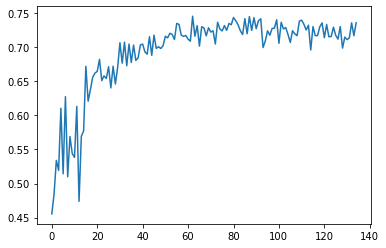

In [33]:
plt.plot(mm.cv_results_['mean_test_f1_score'])

In [34]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       134
           1       0.82      0.67      0.74        89

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223



In [35]:
best_rf=mm.best_estimator_
best_rf.fit(X_i,y)
scores=cross_val_score(best_rf, X_i, y, cv=5,scoring=make_scorer(f1_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.74 (+/- 0.10)


## Multilayer Perceptron

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-3)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-3)]: Done  40 out of  40 | elapsed:    5.2s finished


Best parameter: {'hidden_layer_sizes': (5, 4, 3, 2)}


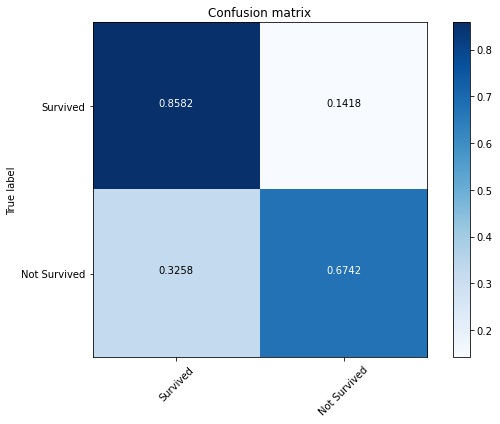

In [36]:
mm,bp,bs=training(X_train,y_train,'Multilayer Perceptron')
print ('Best parameter:', bp)
#print ('Best accuracy:', bs)

predic = mm.predict(X_test)
confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

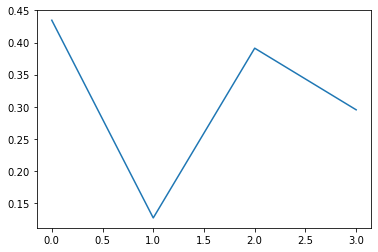

In [37]:
plt.plot(mm.cv_results_['mean_test_f1_score'])

In [38]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       134
           1       0.76      0.67      0.71        89

    accuracy                           0.78       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223



In [39]:
best_mlp=mm.best_estimator_
best_mlp.fit(X_i,y)
scores=cross_val_score(best_mlp, X_i, y, cv=5,scoring=make_scorer(f1_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.71 (+/- 0.08)


## Classification Tree

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best parameter: {'max_depth': 50}


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-3)]: Done  40 out of  40 | elapsed:    0.1s finished


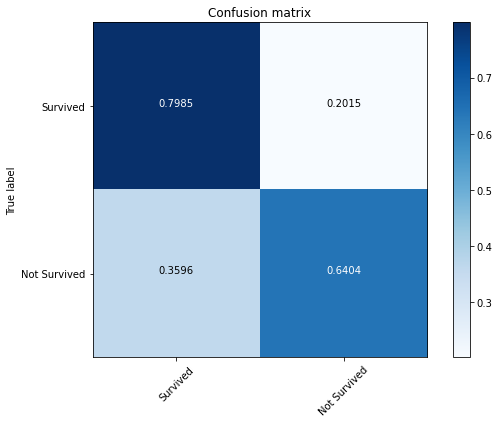

In [40]:
mm,bp,bs=training(X_train,y_train,'Classification Tree')
print ('Best parameter:', bp)
#print ('Best accuracy:', bs)

predic = mm.predict(X_test)
confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

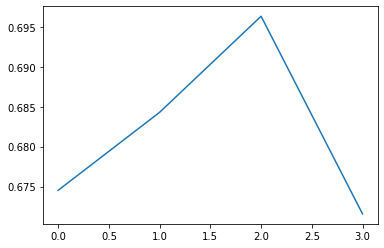

In [41]:
plt.plot(mm.cv_results_['mean_test_f1_score'])

In [42]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78       134
           1       0.68      0.64      0.66        89

    accuracy                           0.74       223
   macro avg       0.72      0.72      0.72       223
weighted avg       0.73      0.74      0.73       223



In [43]:
best_ct=mm.best_estimator_
best_ct.fit(X_i,y)
scores=cross_val_score(best_ct, X_i, y, cv=5,scoring=make_scorer(f1_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.70 (+/- 0.10)


## RBF SVM

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-3)]: Done  92 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-3)]: Done 576 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-3)]: Done 1000 out of 1000 | elapsed:   22.0s finished


Best parameter: {'C': 215.44346900318823, 'gamma': 0.001291549665014884}


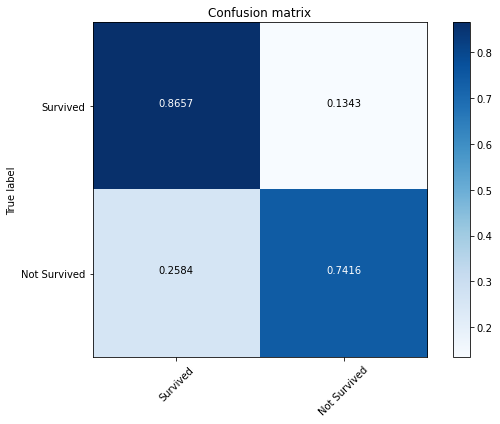

In [44]:
mm,bp,bs=training(X_train,y_train,'RBF SVM')
print ('Best parameter:', bp)
#print ('Best accuracy:', bs)

predic = mm.predict(X_test)
confm = confusion_matrix(y_test, predic,normalize='true')
plot_confusion_matrix(confm,target_names)

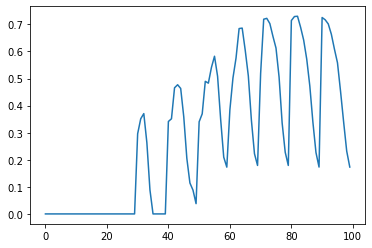

In [45]:
plt.plot(mm.cv_results_['mean_test_f1_score'])

In [46]:
print(metrics.classification_report(y_test, predic))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       134
           1       0.79      0.74      0.76        89

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



In [47]:
best_rbf=mm.best_estimator_
best_rbf.fit(X_i,y)
scores=cross_val_score(best_rbf, X_i, y, cv=5,scoring=make_scorer(f1_score))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.73 (+/- 0.07)


# Prepare the solution

In [51]:
test_data = pd.read_csv("test.csv", encoding="utf8", converters={'Sex': lambda x: int(x == 'male'), 'Embarked' : lambda x: (1 if x=='C' else 0 if x =='Q' else -1 if x=='S' else np.nan)} )

In [52]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,-1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,-1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,-1


In [55]:
test_data.PassengerId.unique().shape

(418,)

In [57]:
X_test   = test_data.drop(columns=['Name','PassengerId','Ticket','Cabin'])
X_test_i = imputer.fit_transform(X_test)

In [58]:
X_test_i.shape

(418, 7)

In [65]:
y_pred = best_rf.predict(X_test_i)

In [66]:
solution = pd.DataFrame({"passenger":test_data.PassengerId.unique(), "survived":y_pred})
solution.head(20)

,passenger,survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [67]:
solution.to_csv("solution_rf.csv", index=False)